In [1]:
#Libraries import
import pandas as pd
from mordred import Calculator, descriptors
import mordred
import numpy as np
from rdkit import Chem

from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
def prepare_data(file):
    
    df = pd.read_excel(file)
    
    try:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
    except:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['new_SMILES']]
    
    calculate_descriptors = True
    
    if calculate_descriptors:
        calc = Calculator(descriptors, ignore_3D=True)
        molecular_descriptors = calc.pandas(mol_objs)
        molecular_descriptors = molecular_descriptors.applymap(is_morder_missing)
        molecular_descriptors = molecular_descriptors[sorted(molecular_descriptors.columns)]
    else:
        pass
    print(molecular_descriptors.shape)
    
    simple_preprocessing = True
    if simple_preprocessing:
        molecular_descriptors_cleaned = molecular_descriptors.dropna(axis=1, how='any')
        molecular_descriptors_cleaned
    print(molecular_descriptors_cleaned.shape)
    molecular_descriptors_cleaned = molecular_descriptors_cleaned.loc[:, (molecular_descriptors_cleaned != 0).any(axis=0)]
    print(molecular_descriptors_cleaned.shape)
    
    try:
        molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] = df['Aktywność cytoprotekcyjna [%]']
    except:
        pass
    
    #try:
        #print('Target distribution histogram: ')
        #print(df['Aktywność cytoprotekcyjna [%]'].hist())
    #except:
        #pass
    
    return molecular_descriptors_cleaned

In [3]:
def is_morder_missing(x):
    return np.nan if type(x) == mordred.error.Missing or type(x) == mordred.error.Error else x 

In [4]:
def correlation_dataframe(molecular_descriptors_cleaned, correlation_threshold):
    
    correlation_table = pd.DataFrame(data=molecular_descriptors_cleaned.columns.to_list(), columns=["molecular descriptor name"])
    print(correlation_table.head())
    correlation_to_ak_cyt = []
    for mol_desc in correlation_table['molecular descriptor name']:
        x = np.corrcoef(np.array(molecular_descriptors_cleaned[mol_desc]), np.array(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]']))
        x = x.tolist()[0][1]
        correlation_to_ak_cyt.append(x)
    correlation_table['corr_value'] = correlation_to_ak_cyt
    print(correlation_table.head())
    correlation_table['absolute correlation value'] = [abs(x) for x in correlation_table['corr_value']]
    print(correlation_table[:-1].head())
    
    mol_desc_best_corr = correlation_table[correlation_table['absolute correlation value'] > correlation_threshold]
    
    print(mol_desc_best_corr.head())
    table_with_descriptors_to_be_used = mol_desc_best_corr[:-1]
    print(table_with_descriptors_to_be_used.head())
    
    #print("Correlation to the target histogram: ")
    #print(correlation_table['absolute correlation value'][:-1].hist(bins=100))
    
    return table_with_descriptors_to_be_used
    

In [5]:
def test_data(molecular_descriptors_cleaned):
    
    test123 = molecular_descriptors_cleaned.loc[(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 90)
                                                | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 70)
                                        | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 45)
                                       | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 10)
                                               | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 0)]
    
    test_data = test123.iloc[[0, 1, 2, 5, 15]] #It allows to get 5 different points of known activity
    
    return test_data
    

In [6]:
def prepare_model(data, features, test_data, max_depth):
    
    X = data[features['molecular descriptor name']]
    
    y = data['Aktywność cytoprotekcyjna [%]']
    
    dtr = DecisionTreeRegressor(random_state=15, max_depth=max_depth)
    
    dtr.fit(X, y)
    print("Return the coefficient of determination of the prediction: ")
    print(dtr.score(test_data[features['molecular descriptor name']], test_data['Aktywność cytoprotekcyjna [%]']))

    pred = dtr.predict(X)
    print("R^2 score: "+ str(r2_score(y, pred)))
    sqrt_r2 = np.sqrt(r2_score(y, pred))
    training_data_r2 = r2_score(y, pred)
    print('Correlation coefficient: '+ str(sqrt_r2))
    print("Test data - unseen during training:")
    pred = dtr.predict(test_data[features['molecular descriptor name']])
    print("R^2 score: "+ str(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])))
    sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
    print('Correlation coefficient: '+ str(sqrt_r2))
    print(pred)
    print(test_data['Aktywność cytoprotekcyjna [%]']) 
    test_data_r2 = r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])
    
    return dtr, training_data_r2, test_data_r2
    

In [7]:
def data_standarization(dataframe):
    
    dataframe_ = dataframe.drop(['Aktywność cytoprotekcyjna [%]'], axis=1)
    
    to_be_returned = (dataframe_ - dataframe_.mean()) / dataframe_.std()
    to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
    
    return to_be_returned

In [8]:
def prepare_data_and_create_model(molecular_descriptors_df, correlation_threshold, standarization, max_depth):
    
    if standarization == True:
        
        print("I am doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        stand = data_standarization(data_to_be_prepared)
        
        corr = correlation_dataframe(stand, correlation_threshold)
        
        test_ = test_data(stand)
        
        data_to_be_prepared = stand.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, test_, max_depth)
        
    elif standarization == False:
        
        print("I am not doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        corr = correlation_dataframe(data_to_be_prepared, correlation_threshold)
        
        test_ = test_data(data_to_be_prepared)
        
        data_to_be_prepared = data_to_be_prepared.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, test_, max_depth)
    else:
        print("Error...")
    
    return model, train_r2, test_r2, data_to_be_prepared, corr
    

In [9]:
molecular_descriptors_df = prepare_data('../Data/initial_caffeine.xlsx')

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 27.79it/s]


(58, 1613)
(58, 1388)
(58, 1137)


In [10]:
without_standarization, train_r2_, test_r2_, hist1, hist2 = prepare_data_and_create_model(molecular_descriptors_df, 0.46, False, 5)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


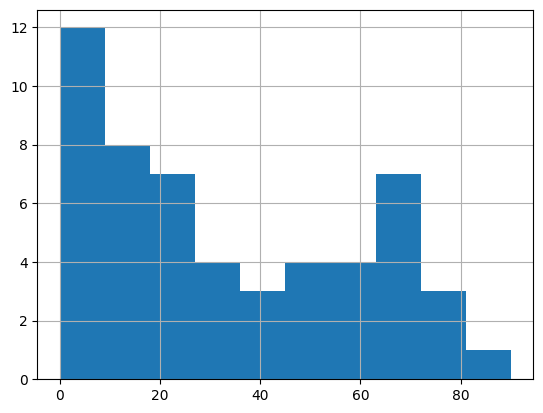

In [11]:
print('Target distribution histogram: ')
print(hist1['Aktywność cytoprotekcyjna [%]'].hist())

In [12]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 4


In [13]:
hist2

,molecular descriptor name,corr_value,absolute correlation value
362,ATSC4s,-0.482595,0.482595
530,GATS2Z,-0.472027,0.472027
646,MATS1Z,-0.464299,0.464299
652,MATS1m,-0.462327,0.462327


In [14]:
with_standarization, train_r2__, test_r2__, hist1_, hist2_ = prepare_data_and_create_model(molecular_descriptors_df, 0.46, True, 5)

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


In [15]:
with_standarization.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 15,
 'splitter': 'best'}

In [16]:
with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']])

array([49.  , 49.  , 49.  , 49.  , 49.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  , 49.  , 49.  ,  0.  ,  0.  ,  0.  , 49.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  , 49.  , 49.  ,  0.  ,  0.  ,
       49.  , 49.  , 49.  , 49.  , 49.  , 49.  , 49.  , 49.  , 49.  ,
       49.  , 49.  , 49.  , 49.  , 49.  , 49.  , 49.  , 49.  , 29.25,
       49.  , 29.25,  0.  ,  0.  ,  0.  ,  0.  , 49.  , 49.  ,  0.  ,
        0.  , 49.  , 49.  , 49.  ])

In [17]:
len(with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']]))

58

In [18]:
xs = r2_score(with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])

In [19]:
xs

-0.4867873951169275

Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


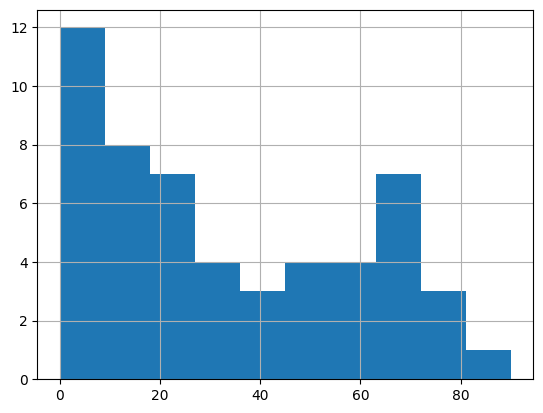

In [20]:
print('Target distribution histogram: ')
print(hist1_['Aktywność cytoprotekcyjna [%]'].hist())

In [21]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 4


In [22]:
hist2_

,molecular descriptor name,corr_value,absolute correlation value
362,ATSC4s,-0.482595,0.482595
530,GATS2Z,-0.472027,0.472027
646,MATS1Z,-0.464299,0.464299
652,MATS1m,-0.462327,0.462327


## Search inside correlation space

In [24]:
step = 0.01
initial_step = 0.3
last_step = 0.48
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
max_depth = [range(2, 30, 1)]
corr_th = []
second_list = []
third_list = []
f_list = []
fif_list = []
for i in first_list:
    for depth in max_depth[0]:
        
        without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, False, depth)
        corr_th.append(i)
        second_list.append(train_r2)
        third_list.append(test_r2)
        f_list.append(len(h_))
        fif_list.append(depth)


I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7            

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

Correlation coefficient: 0.9950244540747081
Test data - unseen during training:
R^2 score: -0.30027647875937413
Correlation coefficient: nan
[65.   9.  42.8 45.  90. ]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encount

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

Return the coefficient of determination of the prediction: 
0.5051020408163265
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -0.18736739023992155
Correlation coefficient: nan
[65.  8. 16. 45. 55.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                 

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

Return the coefficient of determination of the prediction: 
0.4586734693877551
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -0.4568839253020873
Correlation coefficient: nan
[65.  8. 23. 45. 55.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                  

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

Return the coefficient of determination of the prediction: 
0.4586734693877551
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -0.4568839253020873
Correlation coefficient: nan
[65.  8. 23. 45. 55.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                  

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

Return the coefficient of determination of the prediction: 
0.5440476190476191
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: 0.1118987677222738
Correlation coefficient: 0.3345127317790368
[65. 10. 16. 45. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2    

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

Return the coefficient of determination of the prediction: 
0.5440476190476191
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: 0.1118987677222738
Correlation coefficient: 0.3345127317790368
[65. 10. 16. 45. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2    

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

Return the coefficient of determination of the prediction: 
0.254760723733938
R^2 score: 0.9462059830164303
Correlation coefficient: 0.9727311977193033
Test data - unseen during training:
R^2 score: -0.8156693192516902
Correlation coefficient: nan
[65.          3.5        32.91666667 37.5        60.        ]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

Return the coefficient of determination of the prediction: 
0.4726190476190476
R^2 score: 0.9994404976429421
Correlation coefficient: 0.9997202096801595
Test data - unseen during training:
R^2 score: 0.05767594505895224
Correlation coefficient: 0.24015816675464577
[65. 10. 24. 45. 80.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320  

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

Return the coefficient of determination of the prediction: 
0.4806122448979592
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: 0.08376335053402129
Correlation coefficient: 0.28941898786019776
[65. 10. 23. 45. 80.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2  

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: 0.08376335053402129
Correlation coefficient: 0.28941898786019776
[65. 10. 23. 45. 80.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv  

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

Return the coefficient of determination of the prediction: 
0.30102040816326525
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -0.7076616253947148
Correlation coefficient: nan
[65.  8. 41. 45. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                 

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

Return the coefficient of determination of the prediction: 
0.4737088713036235
R^2 score: 0.9937491099830982
Correlation coefficient: 0.9968696554630893
Test data - unseen during training:
R^2 score: -0.22113755403655477
Correlation coefficient: nan
[65.         11.         25.85714286 45.         70.        ]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1               

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

Return the coefficient of determination of the prediction: 
0.4091836734693878
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -0.65965985094592
Correlation coefficient: nan
[65. 15. 32. 45. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

Return the coefficient of determination of the prediction: 
0.4091836734693878
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -0.65965985094592
Correlation coefficient: nan
[65. 15. 32. 45. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

Return the coefficient of determination of the prediction: 
0.17091836734693877
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -2.6931818181818183
Correlation coefficient: nan
[65. 15. 45. 45. 50.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                 

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
Return the coefficient of determination of the prediction: 
-1.029610733182162
R^2 score: 0.9919827132129214
Correlation coefficient: 0.9959832896253438
Test da

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100        

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

Return the coefficient of determination of the prediction: 
-0.24285714285714288
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -1.8560262623104578
Correlation coefficient: nan
[ 8. 45. 15. 23. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

Return the coefficient of determination of the prediction: 
-0.24285714285714288
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -1.8560262623104578
Correlation coefficient: nan
[ 8. 45. 15. 23. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

Return the coefficient of determination of the prediction: 
-0.9302721088435375
R^2 score: 0.9998112522168962
Correlation coefficient: 0.999905621654812
Test data - unseen during training:
R^2 score: -1.6518691588785046
Correlation coefficient: nan
[ 0. 45.  0.  0. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                  

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100        

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

Return the coefficient of determination of the prediction: 
-0.2047619047619047
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -1.2156887276366821
Correlation coefficient: nan
[ 8. 45.  1. 23. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

Return the coefficient of determination of the prediction: 
-0.20306122448979602
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -1.2635351337514402
Correlation coefficient: nan
[55. 15. 15.  8. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

Return the coefficient of determination of the prediction: 
-0.20306122448979602
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -1.2635351337514402
Correlation coefficient: nan
[55. 15. 15.  8. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

Return the coefficient of determination of the prediction: 
-0.7443877551020408
R^2 score: 1.0
Correlation coefficient: 1.0
Test data - unseen during training:
R^2 score: -2.442870569280344
Correlation coefficient: nan
[ 0. 32. 32.  8. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                  

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: Runtime

Correlation coefficient: nan
[23. 40. 15.  1. 70.]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_18864\3503909244.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

In [27]:
df_without_standarization = pd.DataFrame(data=corr_th, columns=["Correlation threshold"])

In [28]:
df_without_standarization['Training data R^2 score'] = second_list
df_without_standarization['Test data R^2 score'] = third_list
df_without_standarization['Number of features'] = f_list
df_without_standarization['Depth number'] = fif_list

In [29]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,Depth number
0,0.30,0.781728,-1.365956,87,2
1,0.30,0.879670,-0.471236,87,3
2,0.30,0.949847,-2.286529,87,4
3,0.30,0.990074,-0.300276,87,5
4,0.30,0.998575,-1.694708,87,6
...,...,...,...,...,...
499,0.47,1.000000,-2.153078,2,25
500,0.47,1.000000,-2.153078,2,26
501,0.47,1.000000,-2.153078,2,27
502,0.47,1.000000,-2.153078,2,28


## Plots

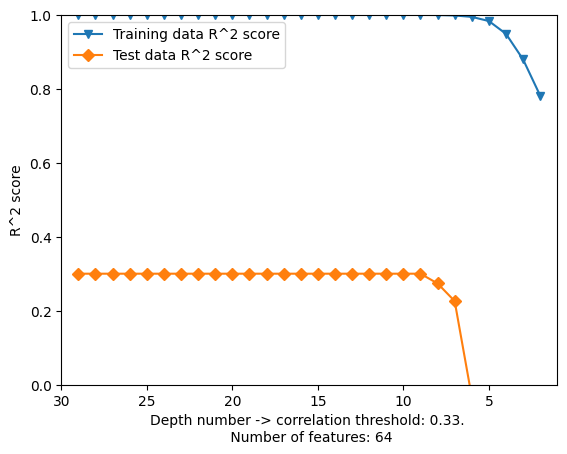

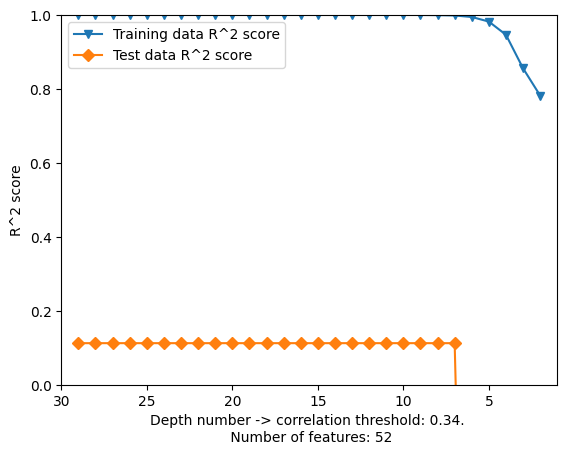

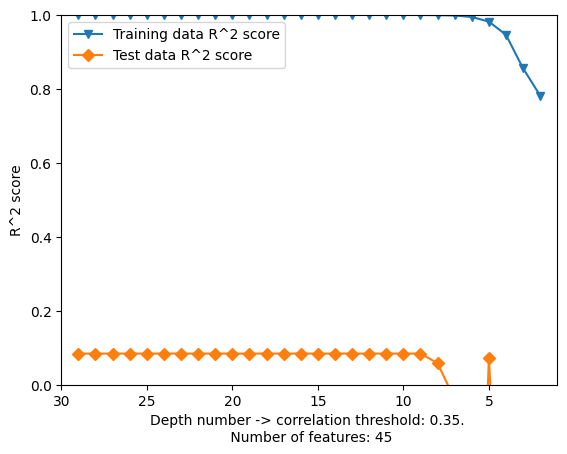

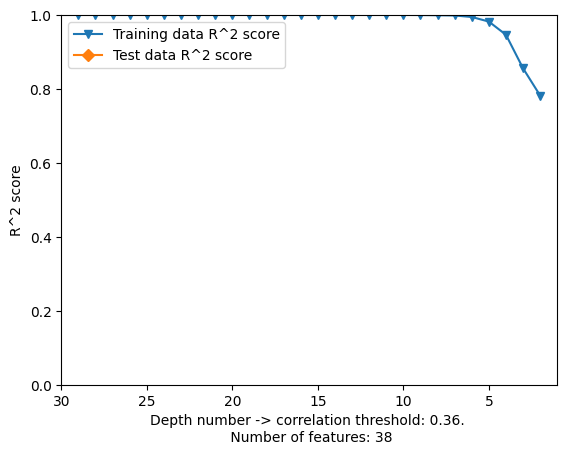

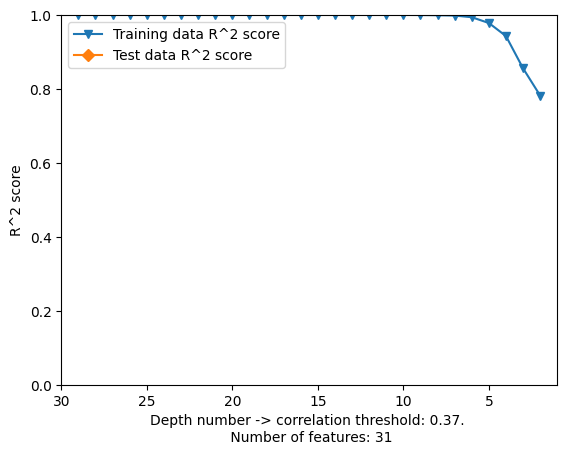

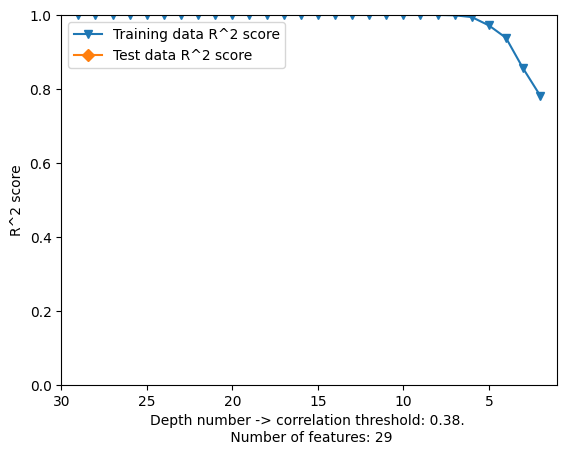

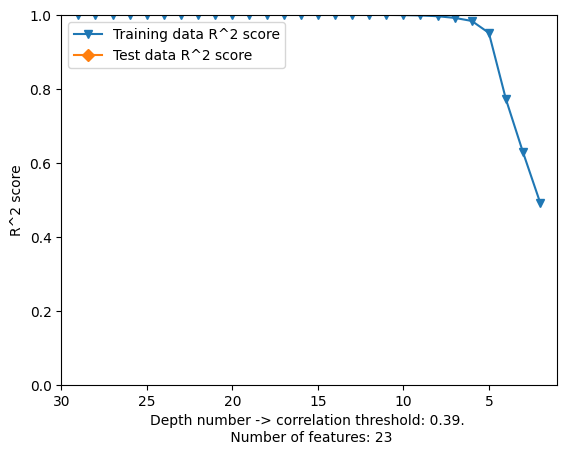

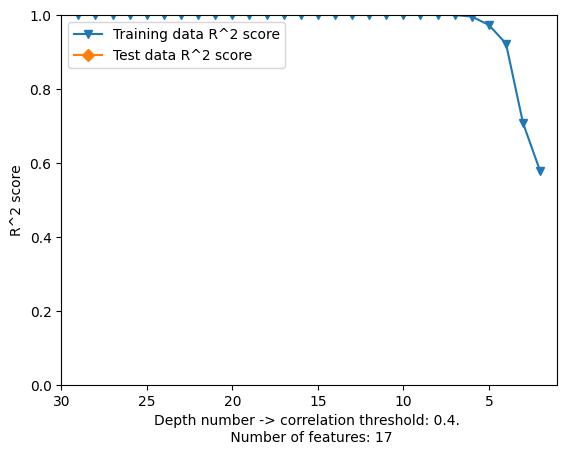

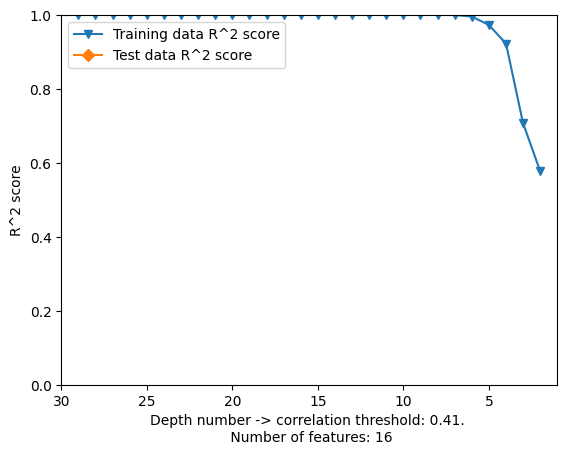

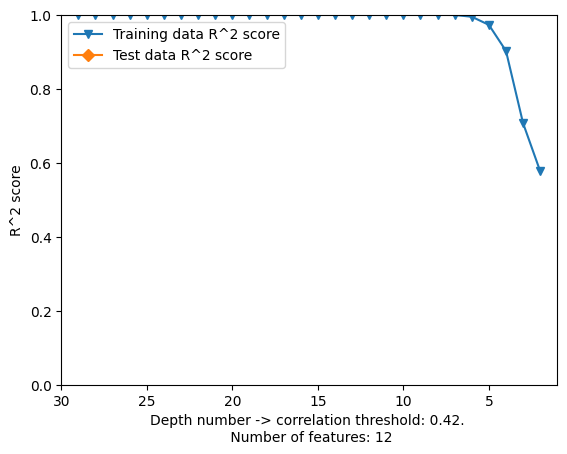

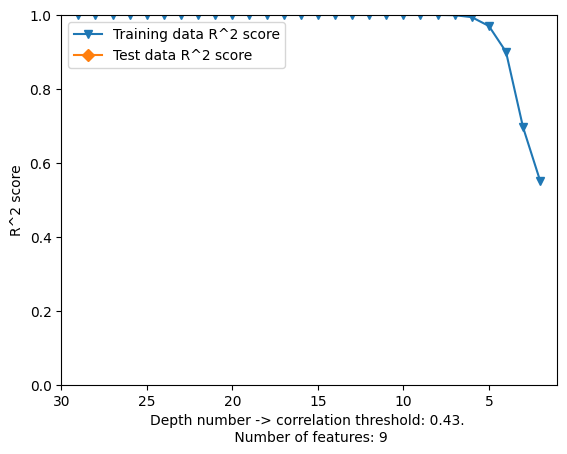

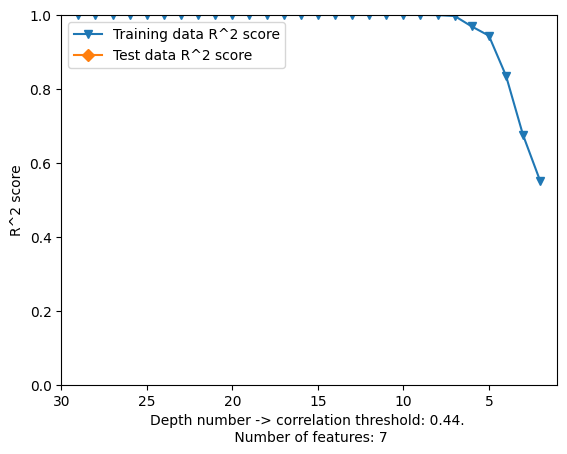

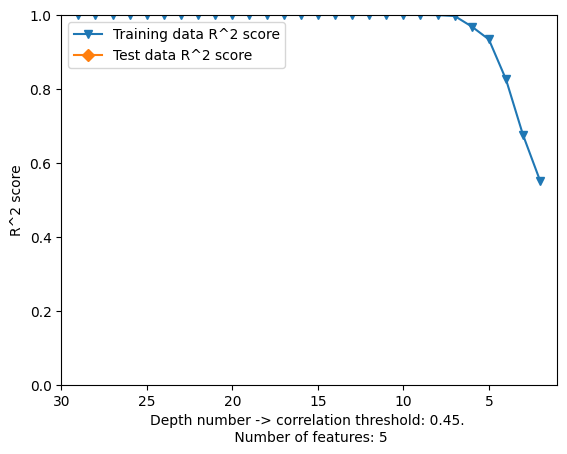

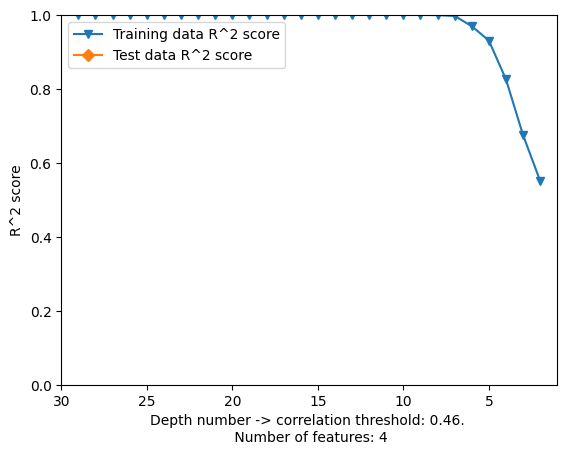

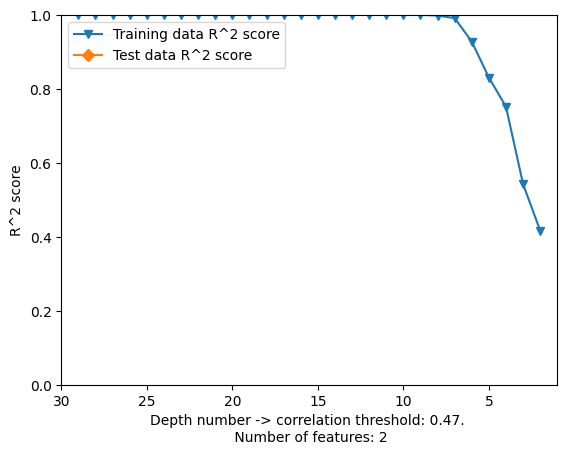

In [30]:
corre_list = [x / 100.0 for x in range(int(0.33*100), int(0.48*100), int(0.01*100))]
for element in corre_list:
    element_ = df_without_standarization[df_without_standarization['Correlation threshold'] == float(element)]
    plt.plot(element_['Depth number'], element_['Training data R^2 score'], label = "Training data R^2 score", marker='v')
    plt.plot(element_['Depth number'], element_['Test data R^2 score'], label = "Test data R^2 score", marker='D')
    plt.legend()
    plt.xlabel('Depth number -> correlation threshold: '+str(element)+'. \n Number of features: '+str(element_['Number of features'].iloc[0]))
    plt.xlim(max(element_['Depth number'])+1, min(element_['Depth number'])-1)
    plt.ylabel('R^2 score')
    plt.ylim([0, 1])
    plt.show()

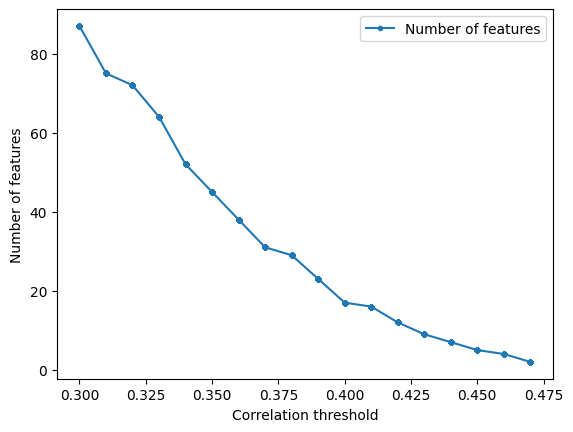

In [31]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

In [32]:
element_ = df_without_standarization[df_without_standarization['Correlation threshold'] == 0.47]
element_

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,Depth number
476,0.47,0.416490,-5.637668,2,2
477,0.47,0.542341,-3.315751,2,3
478,0.47,0.751676,-3.635129,2,4
479,0.47,0.830665,-2.978277,2,5
480,0.47,0.927813,-2.765595,2,6
481,0.47,0.991345,-2.685031,2,7
482,0.47,0.998436,-2.385676,2,8
483,0.47,1.000000,-2.153078,2,9
484,0.47,1.000000,-2.153078,2,10
485,0.47,1.000000,-2.153078,2,11


# sqrt(R^2)

In [ ]:
r_a = df_without_standarization[df_without_standarization['Correlation threshold'] == 0.47]

In [ ]:
r_a['train R value'] = [np.sqrt(x) for x in r_a['Training data R^2 score']]

In [ ]:
xcz = []
for element in r_a['Test data R^2 score']:
    x = np.sqrt(element)
    try:
        if x > 0:
            xcz.append(x)
        else:
            xcz.append(0)
    except:
        pass
    

In [ ]:
xcz

In [ ]:
r_a['test R value'] = xcz

In [ ]:
plt.plot(r_a['Depth number'], r_a['train R value'], label = "train R value", marker='v')
plt.plot(r_a['Depth number'], r_a['test R value'], label = "test R value", marker='D')
plt.legend()
plt.xlabel('Depth number -> correlation threshold: 0.39')
plt.ylabel('R score')
plt.ylim([0, 1])
plt.show()

In [ ]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

## Final model

In [ ]:
break

In [ ]:
final_model = prepare_data_and_create_model(molecular_descriptors_df, 0.33, False)

In [ ]:
final_model[0].get_params()

In [ ]:
final_model[0].intercept_

In [ ]:
final_model[0].coef_

## Predict target feature

In [ ]:
to_prediction = prepare_data('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')

In [ ]:
predicted_activity = final_model[0].predict(to_prediction[final_model[4]['molecular descriptor name']])

In [ ]:
smiles = pd.read_excel('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')
smiles = smiles['new_SMILES']
smiles = smiles.to_list()
save_to_df = pd.DataFrame(data=smiles, columns=['SMILES'])

In [ ]:
print(len(smiles))
print(len(predicted_activity))

In [ ]:
save_to_df.head()

In [ ]:
save_to_df['Predicted activity'] = predicted_activity

In [ ]:
save_to_df.head()

In [ ]:
save_to_df.to_excel('../Data/Predicted_activity.xlsx')